### import statements

In [136]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict
pkl_base_dir = path_dict['pkl_root']

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### local functions


In [146]:
# local functions

# modify timeseries for MUXED data (add Nan frames between values to align with lick/speed)

def align_mux(sess):
    for key in list (sess.timeseries.keys()):
        data=sess.timeseries[key]

        if f'channel_0' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,::2] = data # place chan0 values at even index

        elif f'channel_1' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,1::2] = data # place chan1 values at odd index

        else:
            continue 

        sess.timeseries[key] = new_data
    return sess
    
def chan_mask(sess):
    chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
    chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
    return chan0_nanmask, chan1_nanmask

def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = self.timeseries[df_key]

    if 'channel_0' in df_key:
        keep = np.arange(df.shape[1]) % 2 ==0 
    elif 'channel_1' in df_key:
        keep = np.arange(df.shape[1]) % 2 == 1
    else: 
        raise ValueError(f"df_key '{df_key}' must include channel")

    unmux = df[:,keep]
    self.timeseries[df_key] = unmux 

def trim_vr(sess):
    print(sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1])
    if (sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1]) ==1:
        print('Odd number of VR frames, trimming')
        sess.vr_data.drop(sess.vr_data.tail(1).index,inplace=True) # drop last n rows
    sess.vr_data.shape
    
# create mask for place cells only 
def make_mask(sess): 
    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

    # mask for interneurons
    int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    chan1_mask = np.logical_and(chan1_mask, int_mask1)
    chan0_mask = np.logical_and(chan0_mask, int_mask0)

    chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
    chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
    chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
    chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
    
    sess.place_cell_info['channel_0_F_dff']['left']['masks'] = chan0_left_mask
    sess.place_cell_info['channel_0_F_dff']['right']['masks'] = chan0_right_mask
    sess.place_cell_info['channel_1_F_dff']['left']['masks'] = chan1_left_mask
    sess.place_cell_info['channel_1_F_dff']['right']['masks'] = chan1_right_mask


def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma",aspect = 'auto',interpolation='none')

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

def get_mask(sess):
    chan0_left_mask = sess.place_cell_info['channel_0_F_dff']['left']['masks'] 
    chan0_right_mask = sess.place_cell_info['channel_0_F_dff']['right']['masks'] 
    chan1_left_mask = sess.place_cell_info['channel_1_F_dff']['left']['masks'] 
    chan1_right_mask=sess.place_cell_info['channel_1_F_dff']['right']['masks'] 

    return chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask

def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    source_folder =  "Z://giocomo/InVivoDA/2P_Data/"
    # souce_folder = "Z://giocomo/esay/Stx3/S2Data"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
              'n_channels': 2,
             })
    return f

def save_trial_teleport_inds(sess):
    
    sess.trial_starts = {'channel_0': None, 
                            'channel_1': None
                            }
    sess.trial_ends = {'channel_0': None, 
                            'channel_1': None
                            }

    chan0_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan0_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan1_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan1_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan0_start[chan0_start % 2 == 1] += 1
    chan0_ends[chan0_ends % 2 == 1] -= 1

    chan1_start[chan1_start % 2 == 0] += 1
    chan1_ends[chan1_ends % 2 == 0] -= 1
    
    sess.trial_starts['channel_0'] = chan0_start//2
    sess.trial_starts['channel_1'] = chan1_start//2
    sess.trial_ends['channel_0']  = chan0_ends//2
    sess.trial_ends['channel_1'] = chan1_ends//2


### function to run place cell calculation UNMUXED

In [94]:
def run_and_save(fdict,comb_frames=0):  
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P(mux=True)
    sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
    # sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()

    # align alternate frames for muxed days
    sess = align_mux(sess)
    chan0_nanmask, chan1_nanmask = chan_mask(sess)

    # if VR is too long, trim by one frame
    trim_vr(sess)


    # calculate dff with alternating frames masked
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                                Fneukey='channel_1_Fneu', 
                                tau=sess.s2p_ops['channel_1']['tau'],
                                   chan_mask = chan1_nanmask,
                                spks_key='channel_1_spks')
    
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    fig,ax = plt.subplots()
    ax.plot(speed[:5000])
    
    # speed filtered dff
    ## change to dff NOT spks
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

    # speed filtered spks
    spks = np.copy(sess.timeseries['channel_0_spks'])
    sess.add_timeseries(channel_0_spks_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_spks_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_spks'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_spks_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_spks_speed_filt')

    # normalized spks (for activity analysis) 
    sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
    sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_1_spks_norm')


    
    # calculate place cells using dff 
    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

    
    make_mask(sess)
    
    # remove nan values 
    reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
    reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')
    
    output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
    tpu.sess.save_session(sess,output_path)
    return comb_frames+sess.scan_info['max_idx']

### debugging interneuron filter

In [185]:
mouse = 'SparseKO_06'
day = 0

In [186]:
sess = u.load_single_day(mouse, day)

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1, 'mouse': 'SparseKO_06', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_06\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_007.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_06\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_007.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_06\\26_05_2025\\YMaze_LNovel_4.sqlite', 'scan_number': 7, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}


In [139]:
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)

C_trial_mat shape:  (10, 30, 318)
non nans in C trial mat:  94128
perm 0
C_trial_mat shape:  (56, 30, 318)
non nans in C trial mat:  533922
perm 0
C_trial_mat shape:  (10, 30, 70)
non nans in C trial mat:  21000
perm 0
C_trial_mat shape:  (56, 30, 70)
non nans in C trial mat:  117460
perm 0


In [128]:
 np.count_nonzero(int_mask)

306

In [101]:
# def z_score_dff(sess, chan1_pre=0, chan0_pre = 0, chan1_post=0, chan0_post = 0):

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

# chan0_pre +=np.count_nonzero(chan0_mask)
# chan1_pre+= np.count_nonzero(chan1_mask)


int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='z_score',
                                prct=10, r_thresh=0.18, mux = True)
    
int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='z_score',
                            prct=10, r_thresh=0.18, mux = True)

chan1_mask_post = np.logical_and(chan1_mask, int_mask1)
chan0_mask_post = np.logical_and(chan0_mask, int_mask0)

chan0_post += np.count_nonzero(chan0_mask_post)
chan1_post+=np.count_nonzero(chan1_mask_post)

    # return chan0_pre,chan1_pre, chan0_post, chan1_post


In [206]:
dff = 0
spks = 0
for mouse in mice:
    for day in range(6):
        sess = u.load_single_day(mouse, day)
        
        dff_mask = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                        prct=10, r_thresh=0.25, mux = True)
        spks_mask = u.is_putative_interneuron(sess, ts_key='channel_0_spks', method='speed',
                                        prct=10, r_thresh=0.25, mux = True)

        dff += np.count_nonzero(dff_mask)
        spks += np.count_nonzero(spks_mask)

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.sbx', 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_02\\16_11_2024\\YMaze_LNovel_4.sqlite', 'scan_number': 14, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\17_11_2024\\YMaze_LNovel\\YMaze_LNovel_001_025.sbx', 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\17_11_2024\\YMaze_LNovel\\YMaze_LNovel_001_025.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_02\\17_11_2024\\YMaze_LNovel_1.sqlite', 's

In [208]:
dff, spks

(9370, 9689)

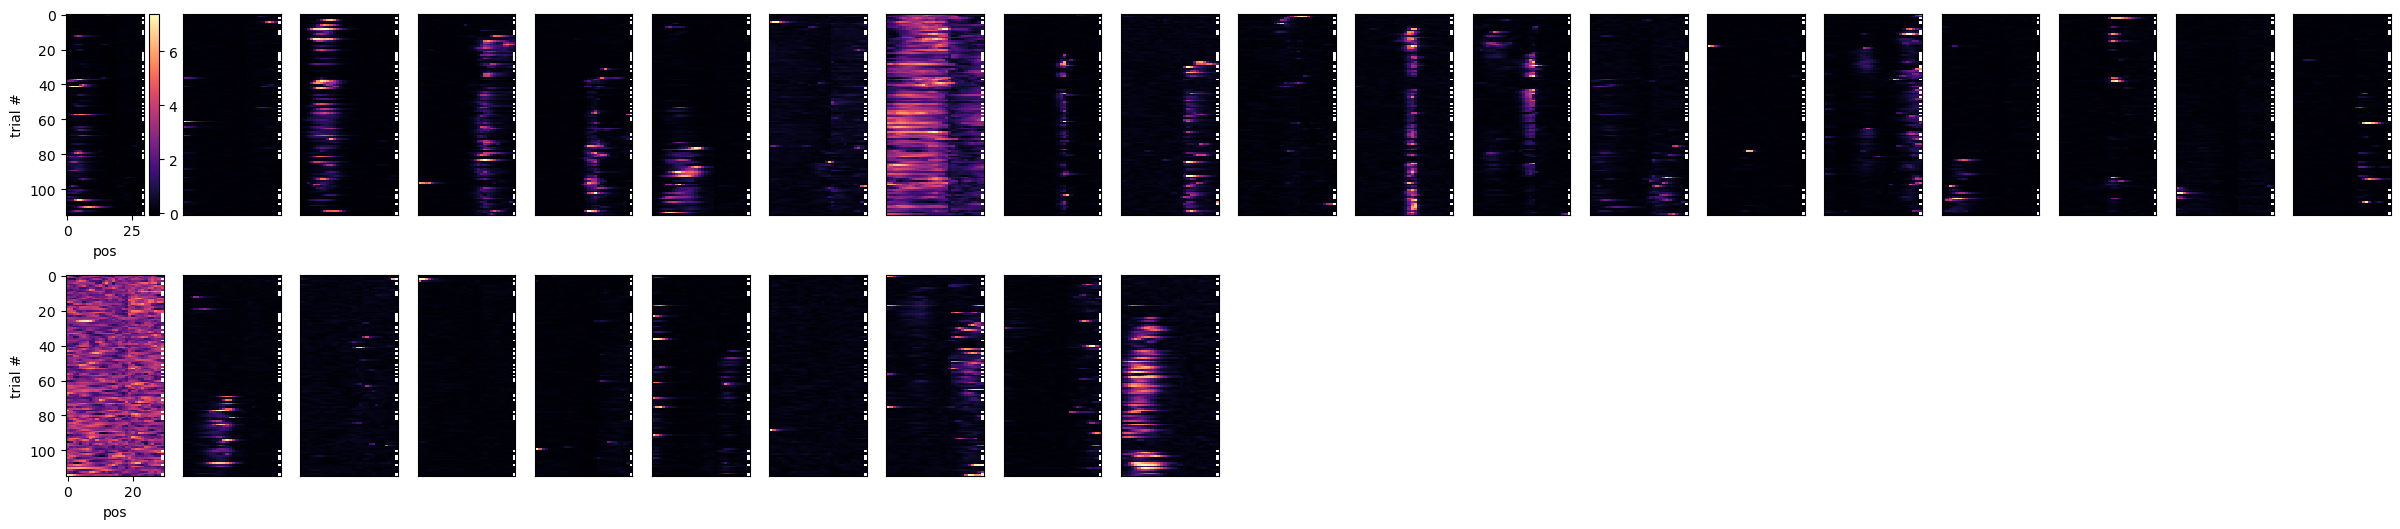

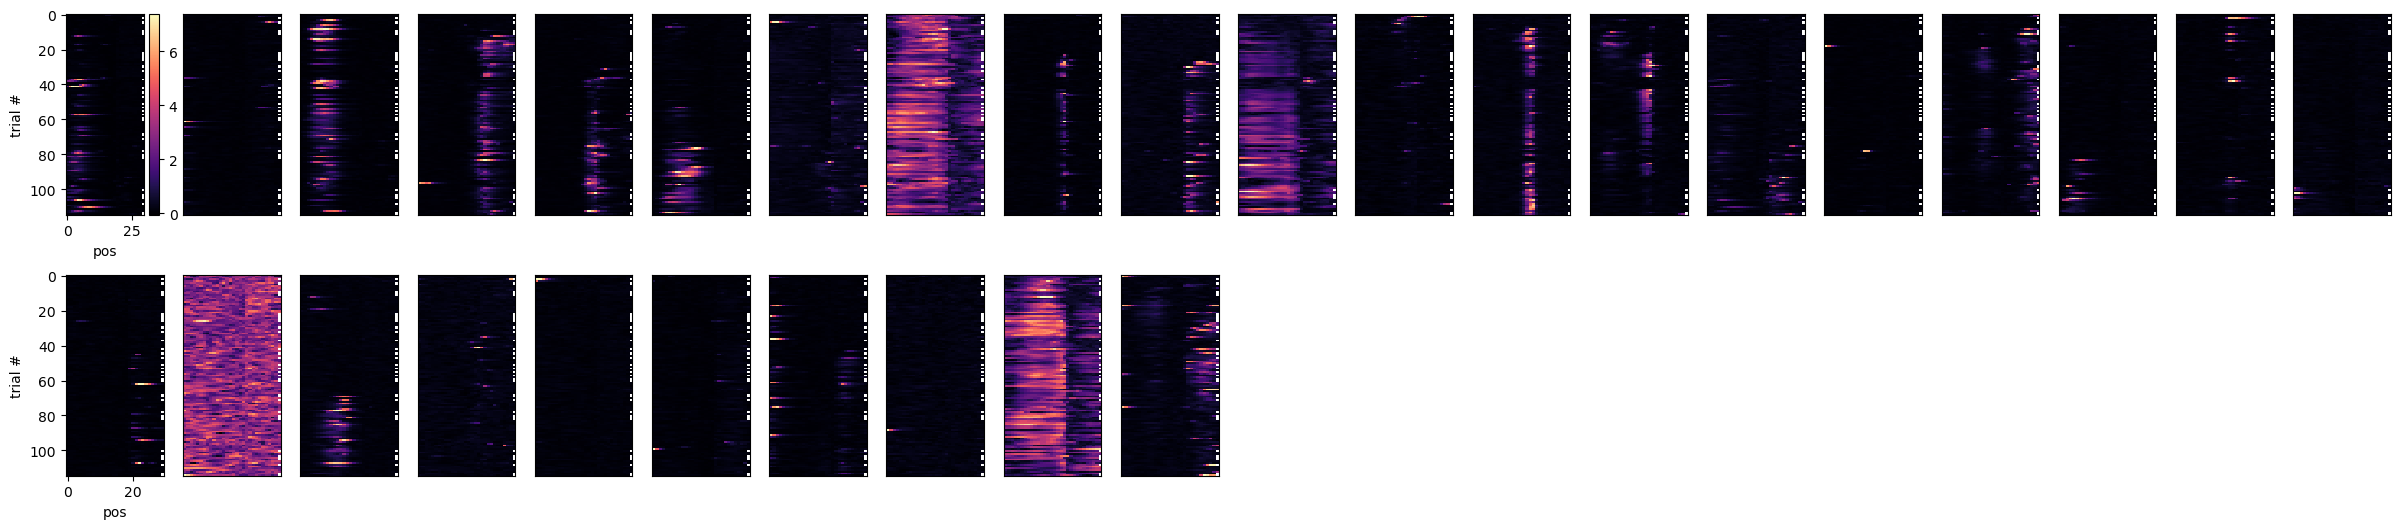

In [204]:
tmat = sess.trial_matrices['channel_0_F_dff']

n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(spks_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=pc_idx[0:30])

fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=np.array([r for r in range(0,30)]))

In [102]:
mice = sparse_mice

all_corrs= []
for mouse in mice: 
    for day in range(6):
        sess = u.load_single_day(mouse, day)
        sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
        sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)
        chan0_pre, chan1_pre, chan0_post, chan1_post = count_cell(sess)
    all_corrs.append({
        'mouse': mouse, 
        'chan0_pre': chan0_pre,
        'chan1_pre':chan1_pre,
        'chan0_post':chan0_post,
        'chan1_post':chan1_post
    })
summary_df = pd.DataFrame(all_corrs)
        

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.sbx', 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_02\\16_11_2024\\YMaze_LNovel_4.sqlite', 'scan_number': 14, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
C_trial_mat shape:  (10, 30, 318)
non nans in C trial mat:  94128
perm 0
C_trial_mat shape:  (56, 30, 318)
non nans in C trial mat:  533922
perm 0
C_trial_mat shape:  (10, 30, 70)
non nans in C trial mat:  21000
perm 0
C_trial_mat shape:  (56, 30, 70)
non nans in C trial mat:  117460
perm 0
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/

KeyboardInterrupt: 

In [105]:
all_corrs

[{'mouse': 'SparseKO_02',
  'chan0_pre': 218,
  'chan1_pre': 76,
  'chan0_post': 193,
  'chan1_post': 64},
 {'mouse': 'SparseKO_06',
  'chan0_pre': 179,
  'chan1_pre': 59,
  'chan0_post': 153,
  'chan1_post': 50}]

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.sbx', 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_02\\16_11_2024\\YMaze_LNovel_4.sqlite', 'scan_number': 14, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2, 'mouse': 'SparseKO_02', 'scan_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\17_11_2024\\YMaze_LNovel\\YMaze_LNovel_001_025.sbx', 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData\\SparseKO_02\\17_11_2024\\YMaze_LNovel\\YMaze_LNovel_001_025.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_02\\17_11_2024\\YMaze_LNovel_1.sqlite', 's

(array([ 1.,  2.,  6., 20., 55., 73., 50.,  7.,  2.,  1.]),
 array([-0.46623985, -0.37724246, -0.28824507, -0.19924768, -0.11025029,
        -0.02125291,  0.06774448,  0.15674187,  0.24573926,  0.33473665,
         0.42373404]),
 <BarContainer object of 10 artists>)

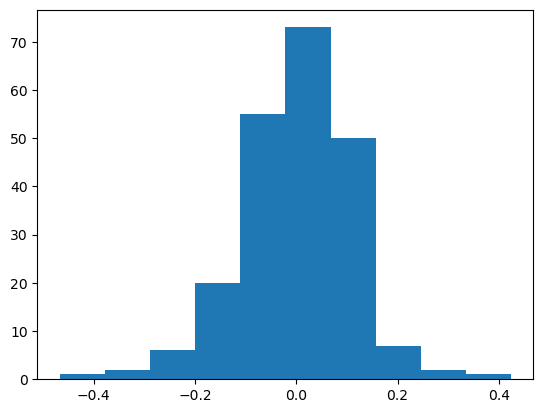

In [109]:
# calculate correlation with speed for each cell 
# plot all correlations as a distribution
# cut off second mode 

ts_key = 'channel_0_F_dff'
mice = sparse_mice

all_corrs= []
for mouse in mice: 
    for day in range(6):
        sess = u.load_single_day(mouse, day)

        use_trial_mat = np.copy(sess.trial_matrices[ts_key][0])
        if 'channel_0' in ts_key:
            speed = np.copy(sess.vr_data_chan0['speed']._values)
        elif 'channel_1' in ts_key:
            speed  = np.copy(sess.vr_data_chan1['speed']._values)
                    
        speed_corr = np.zeros((use_trial_mat.shape[1],))
        nanmask = ~np.isnan(sess.timeseries[ts_key][0, :])
        
        for c in range(use_trial_mat.shape[1]):
            speed_corr[c] = np.corrcoef(
                sess.timeseries[ts_key][c, nanmask], speed[nanmask])[0, 1]
            
        all_corrs.extend(speed_corr[~np.isnan(speed_corr)])

# Convert to numpy array if needed
all_corrs = np.array(all_corrs)

plt.hist(speed_corr)

0.1852823184191562

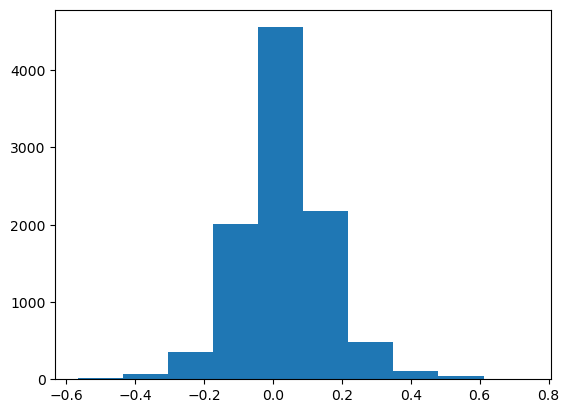

In [112]:
plt.hist(all_corrs)
np.percentile(all_corrs, 90)

### run and save MUXED version

In [147]:
def make_mask(sess, Fkeys = ['F_dff', 'spks','F_dff_speed_filt', 'spks_speed_filt', 'spks_smooth']): 
    print('Making mask for place cells and interneurons')
    for chan in ['channel_0', 'channel_1']:
        for key in Fkeys:
            Fkey = chan + '_' + key
            chan0_mask_pf_left = sess.place_cell_info[Fkey]['left']['masks']
            chan0_mask_pf_right = sess.place_cell_info[Fkey]['right']['masks']
            chan1_mask_pf_left = sess.place_cell_info[Fkey]['left']['masks']
            chan1_mask_pf_right = sess.place_cell_info[Fkey]['right']['masks']
            
            chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
            chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right
        
            # mask for interneurons
            int_mask1 = u.is_putative_interneuron(sess, ts_key=Fkey, method='speed',
                                        prct=10, r_thresh=0.25, mux = True)
            int_mask0 = u.is_putative_interneuron(sess, ts_key=Fkey, method='speed',
                                        prct=10, r_thresh=0.25, mux = True)
            
            chan1_mask = np.logical_and(chan1_mask, int_mask1)
            chan0_mask = np.logical_and(chan0_mask, int_mask0)
        
            chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
            chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
            chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
            chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
            
            
            sess.place_cell_info[Fkey]['left']['masks'] = chan0_left_mask
            sess.place_cell_info[Fkey]['right']['masks'] = chan0_right_mask
            sess.place_cell_info[Fkey]['left']['masks'] = chan1_left_mask
            sess.place_cell_info[Fkey]['right']['masks'] = chan1_right_mask

def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    source_folder =  "Z://giocomo/InVivoDA/2P_Data/"
    # source_folder =  "Z://giocomo/esay/Stx3/2pData"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
              'n_channels': 2,
             })
    return f
def save_trial_teleport_inds(sess):
    
    sess.trial_starts = {'channel_0': None, 
                            'channel_1': None
                            }
    sess.trial_ends = {'channel_0': None, 
                            'channel_1': None
                            }

    chan0_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan0_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan1_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan1_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan0_start[chan0_start % 2 == 1] += 1
    chan0_ends[chan0_ends % 2 == 1] -= 1

    chan1_start[chan1_start % 2 == 0] += 1
    chan1_ends[chan1_ends % 2 == 0] -= 1
    
    sess.trial_starts['channel_0'] = chan0_start//2
    sess.trial_starts['channel_1'] = chan1_start//2
    sess.trial_ends['channel_0']  = chan0_ends//2
    sess.trial_ends['channel_1'] = chan1_ends//2

In [148]:
def run_and_save_mux(fdict,comb_frames=0):  
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P(mux=True)
    sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
    # sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()
    save_trial_teleport_inds(sess)


    # calculate neuropil corrected dff for BOTH channels (two channels, one function?? amazing)

    sess.neuropil_corrected_dff_mux(Fkey_ = 'F',
                                Fneukey_ = 'Fneu',
                                channels = ['channel_0', 'channel_1'],
                                spks_key_ = 'spks')
    # add speed to timeseries

    sess.add_timeseries_mux(channel_0_licks=sess.vr_data_chan0['lick']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_0_licks', channel = 'channel_0')
    channel_0_speed = sess.vr_data_chan0['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries_mux(channel_0_speed=sess.vr_data_chan0['dz']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_0_speed', channel = 'channel_0')
    
    # fig,ax = plt.subplots()
    # ax.plot(channel_0_speed[:5000])
    
    sess.add_timeseries_mux(channel_1_licks=sess.vr_data_chan1['lick']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_1_licks', channel = 'channel_1')
    channel_1_speed = sess.vr_data_chan1['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries_mux(channel_1_speed=sess.vr_data_chan1['dz']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_1_speed', channel = 'channel_1')
    
    # fig,ax = plt.subplots()
    # ax.plot(channel_1_speed[:5000])

    # speed filtered dff
    ## change to dff NOT spks
    dff = np.copy(sess.timeseries['channel_0_F_dff'])
    sess.add_timeseries_mux(channel_0_F_dff_speed_filt=dff)
    dff[:,channel_0_speed<2]=np.nan
    sess.add_pos_binned_trial_matrix_mux('channel_0_F_dff_speed_filt', channel = 'channel_0')
    dff = np.copy(sess.timeseries['channel_1_F_dff'])
    dff[:,channel_1_speed<2]=np.nan
    sess.add_timeseries_mux(channel_1_F_dff_speed_filt=dff)
    sess.add_pos_binned_trial_matrix_mux('channel_1_F_dff_speed_filt', channel = 'channel_1')
    
    # speed filtered spks
    spks = np.copy(sess.timeseries['channel_0_spks'])
    sess.add_timeseries_mux(channel_0_spks_speed_filt=spks)
    spks[:,channel_0_speed<2]=np.nan
    sess.add_pos_binned_trial_matrix_mux('channel_0_spks_speed_filt', channel = 'channel_0')
    spks = np.copy(sess.timeseries['channel_1_spks'])
    spks[:,channel_1_speed<2]=np.nan
    sess.add_timeseries_mux(channel_1_spks_speed_filt=spks)
    sess.add_pos_binned_trial_matrix_mux('channel_1_spks_speed_filt', channel = 'channel_1')

    # normalized spks (for activity analysis) 
    # sess.add_timeseries_mux(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
    # sess.add_pos_binned_trial_matrix_mux('channel_0_spks_norm', pos_key = 't', channel = 'channel_0')
    # sess.add_timeseries_mux(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
    # sess.add_pos_binned_trial_matrix_mux('channel_1_spks_norm', pos_key = 't', channel = 'channel_1')

    sess.add_timeseries_mux(channel_0_spks_smooth = sess.timeseries['channel_0_spks'])
    sess.add_pos_binned_trial_matrix_mux('channel_0_spks_smooth', pos_key = 't', channel = 'channel_0', smooth = True)
    sess.add_timeseries_mux(channel_1_spks_smooth = sess.timeseries['channel_1_spks'])
    sess.add_pos_binned_trial_matrix_mux('channel_1_spks_smooth', pos_key = 't', channel = 'channel_1', smooth= True)

    # actually disgusting block of code to calc place cells with different values

    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_F_dff_speed_filt', out_key='channel_0_F_dff_speed_filt', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_F_dff_speed_filt', out_key='channel_1_F_dff_speed_filt', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_spks_speed_filt', out_key='channel_0_spks_speed_filt', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_spks_speed_filt', out_key='channel_1_spks_speed_filt', nperms=100, mux = True)

    sess.place_cells_calc(Fkey='channel_0_spks_smooth', out_key='channel_0_spks_smooth', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_spks_smooth', out_key='channel_1_spks_smooth', nperms=100, mux = True)

    make_mask(sess)

    # save the damn pickle u idiot
    # output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/smooth_spks")
    # tpu.sess.save_session(sess,output_path)

    return sess

### troubelshotting

In [7]:
mouse = 'SparseKO_13'

f = stx.ymaze_sess_deets.SparseKO_sessions[mouse][0]
f_ = update_sess_dict(mouse,f)
sess = stx.session.YMazeSession(**f_)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P(mux=True)
sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
# sess.load_suite2p_data(which_ts=('F', 'Fneu'))
sess.get_trial_info()
save_trial_teleport_inds(sess)

Fixing teleports
frame rate 31.25
(131765,) ttl times,(60151,) ca2+ frame times
last time: VR 1924.8773125, ca2+ 1924.8
frame rate 31.25
(131765,) ttl times,(60151,) ca2+ frame times
last time: VR 1924.8773125, ca2+ 1924.8
(30076, 17) (30076, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\24_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_027\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\24_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_027\\chan2/suite2p']
Odd number of VR frames, trimming
1
2
3
4
5


In [8]:
sess.neuropil_corrected_dff_mux(Fkey_ = 'F',
                                Fneukey_ = 'Fneu',
                                channels = ['channel_0', 'channel_1'],
                                spks_key_ = 'spks')

227 4802
5741 10001
10940 14680
15619 18984
19921 23088
24027 30075
226 4801
5740 10001
10939 14679
15618 18983
19920 23087
24027 30074


In [130]:
sess.trial_info['LR']

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.])

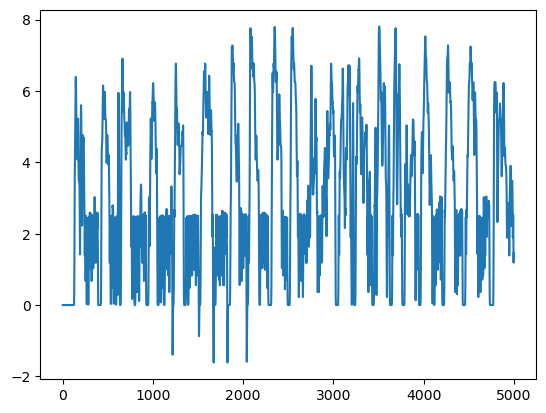

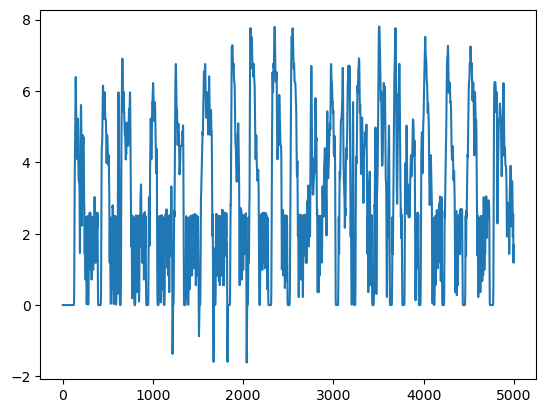

In [9]:
sess.add_timeseries_mux(channel_0_licks=sess.vr_data_chan0['lick']._values)
sess.add_pos_binned_trial_matrix_mux('channel_0_licks', channel = 'channel_0')
channel_0_speed = sess.vr_data_chan0['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries_mux(channel_0_speed=sess.vr_data_chan0['dz']._values)
sess.add_pos_binned_trial_matrix_mux('channel_0_speed', channel = 'channel_0')

fig,ax = plt.subplots()
ax.plot(channel_0_speed[:5000])

sess.add_timeseries_mux(channel_1_licks=sess.vr_data_chan1['lick']._values)
sess.add_pos_binned_trial_matrix_mux('channel_1_licks', channel = 'channel_1')
channel_1_speed = sess.vr_data_chan1['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries_mux(channel_1_speed=sess.vr_data_chan1['dz']._values)
sess.add_pos_binned_trial_matrix_mux('channel_1_speed', channel = 'channel_1')

fig,ax = plt.subplots()
ax.plot(channel_1_speed[:5000])



In [138]:

# speed filtered dff
## change to dff NOT spks
dff = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries_mux(channel_0_F_dff_speed_filt=dff)
dff[:,channel_0_speed<2]=np.nan
sess.add_pos_binned_trial_matrix_mux('channel_0_F_dff_speed_filt', channel = 'channel_0')
dff = np.copy(sess.timeseries['channel_1_F_dff'])
dff[:,channel_1_speed<2]=np.nan
sess.add_timeseries_mux(channel_1_F_dff_speed_filt=dff)
sess.add_pos_binned_trial_matrix_mux('channel_1_F_dff_speed_filt', channel = 'channel_1')

# speed filtered spks
spks = np.copy(sess.timeseries['channel_0_spks'])
sess.add_timeseries_mux(channel_0_spks_speed_filt=spks)
spks[:,channel_0_speed<2]=np.nan
sess.add_pos_binned_trial_matrix_mux('channel_0_spks_speed_filt', channel = 'channel_0')
spks = np.copy(sess.timeseries['channel_1_spks'])
spks[:,channel_1_speed<2]=np.nan
sess.add_timeseries_mux(channel_1_spks_speed_filt=spks)
sess.add_pos_binned_trial_matrix_mux('channel_1_spks_speed_filt', channel = 'channel_1')

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


In [12]:
sess.add_timeseries_mux(channel_0_spks_smooth = sess.timeseries['channel_0_spks'])
sess.add_pos_binned_trial_matrix_mux('channel_0_spks_smooth', pos_key = 't', channel = 'channel_0', smooth = True)
sess.add_timeseries_mux(channel_1_spks_smooth = sess.timeseries['channel_1_spks'])
sess.add_pos_binned_trial_matrix_mux('channel_1_spks_smooth', pos_key = 't', channel = 'channel_1', smooth= True)

In [139]:
# normalized spks (for activity analysis) 
sess.add_timeseries_mux(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix_mux('channel_0_spks_norm', pos_key = 't', channel = 'channel_0')
sess.add_timeseries_mux(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix_mux('channel_1_spks_norm', pos_key = 't', channel = 'channel_1')

In [13]:
sess.place_cells_calc(Fkey='channel_0_spks_smooth', out_key='channel_0_spks_smooth', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_spks_smooth', out_key='channel_1_spks_smooth', nperms=100, mux = True)

C_trial_mat shape:  (121, 30, 284)
non nans in C trial mat:  1000248
perm 0
C_trial_mat shape:  (19, 30, 284)
non nans in C trial mat:  158756
perm 0
C_trial_mat shape:  (121, 30, 118)
non nans in C trial mat:  416422
perm 0
C_trial_mat shape:  (19, 30, 118)
non nans in C trial mat:  65962
perm 0


In [140]:
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_0_F_dff_speed_filt', out_key='channel_0_F_dff_speed_filt', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_F_dff_speed_filt', out_key='channel_1_F_dff_speed_filt', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_0_spks_speed_filt', out_key='channel_0_spks_speed_filt', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_spks_speed_filt', out_key='channel_1_spks_speed_filt', nperms=100, mux = True)

C_trial_mat shape:  (121, 30, 284)
non nans in C trial mat:  1000248
perm 0
C_trial_mat shape:  (19, 30, 284)
non nans in C trial mat:  158756
perm 0
C_trial_mat shape:  (121, 30, 118)
non nans in C trial mat:  416422
perm 0
C_trial_mat shape:  (19, 30, 118)
non nans in C trial mat:  65962
perm 0
C_trial_mat shape:  (121, 30, 284)
non nans in C trial mat:  1000248
perm 0
C_trial_mat shape:  (19, 30, 284)
non nans in C trial mat:  158756
perm 0
C_trial_mat shape:  (121, 30, 118)
non nans in C trial mat:  416422
perm 0
C_trial_mat shape:  (19, 30, 118)
non nans in C trial mat:  65962
perm 0
C_trial_mat shape:  (121, 30, 284)
non nans in C trial mat:  999680
perm 0
C_trial_mat shape:  (19, 30, 284)
non nans in C trial mat:  158472
perm 0
C_trial_mat shape:  (121, 30, 118)
non nans in C trial mat:  416186
perm 0
C_trial_mat shape:  (19, 30, 118)
non nans in C trial mat:  65726
perm 0
C_trial_mat shape:  (121, 30, 284)
non nans in C trial mat:  999680
perm 0
C_trial_mat shape:  (19, 30, 284

In [14]:
make_mask(sess)

Making mask for place cells and interneurons


KeyError: 'channel_0_F_dff'

In [16]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/smooth_spks")
tpu.sess.save_session(sess,output_path)

### active code


In [143]:
mice = stx.ymaze_sess_deets.sparse_mice
mice[5:]

('SparseKO_13',)

In [151]:
# mice = ['SparseKO_13', 'SparseKO_09']
for mouse in mice[5:]:

    for f in stx.ymaze_sess_deets.SparseKO_sessions[mouse][1:2]:
    #     print(f)
    
        
        if isinstance(f,dict):
            f_ = update_sess_dict(mouse,f)
            print(f_)
            _ = run_and_save_mux(f_)



{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2, 'mouse': 'SparseKO_13', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\25_05_2025\\YMaze_LNovel\\YMaze_LNovel_002_008.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\25_05_2025\\YMaze_LNovel\\YMaze_LNovel_002_008.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_13\\25_05_2025\\YMaze_LNovel_2.sqlite', 'scan_number': 8, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(112792,) ttl times,(45569,) ca2+ frame times
last time: VR 1458.2511875, ca2+ 1458.176
frame rate 31.25
(112792,) ttl times,(45569,) ca2+ frame times
last time: VR 1458.2511875, ca2+ 1458.176
(22785, 17) (22785, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\25_05_2025\\YMaze_LNovel\\YMaze_LNovel_002_008\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13\\25_05_2025\\YMaze_LNovel\\YMaze_LNovel_002_008\\chan2/suite2p

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:203: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:219: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


C_trial_mat shape:  (122, 30, 138)
non nans in C trial mat:  488796
perm 0
C_trial_mat shape:  (18, 30, 138)
non nans in C trial mat:  72726
perm 0
C_trial_mat shape:  (122, 30, 224)
non nans in C trial mat:  793184
perm 0
C_trial_mat shape:  (18, 30, 224)
non nans in C trial mat:  116928
perm 0
C_trial_mat shape:  (122, 30, 138)
non nans in C trial mat:  488796
perm 0
C_trial_mat shape:  (18, 30, 138)
non nans in C trial mat:  72726
perm 0
C_trial_mat shape:  (122, 30, 224)
non nans in C trial mat:  793184
perm 0


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:74: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


C_trial_mat shape:  (18, 30, 224)
non nans in C trial mat:  116928
perm 0
C_trial_mat shape:  (122, 30, 138)
non nans in C trial mat:  488796
perm 0
C_trial_mat shape:  (18, 30, 138)
non nans in C trial mat:  72726
perm 0
C_trial_mat shape:  (122, 30, 224)
non nans in C trial mat:  793184
perm 0
C_trial_mat shape:  (18, 30, 224)
non nans in C trial mat:  116928
perm 0
C_trial_mat shape:  (122, 30, 138)
non nans in C trial mat:  488796
perm 0
C_trial_mat shape:  (18, 30, 138)
non nans in C trial mat:  72726
perm 0
C_trial_mat shape:  (122, 30, 224)
non nans in C trial mat:  793184
perm 0
C_trial_mat shape:  (18, 30, 224)
non nans in C trial mat:  116928
perm 0
C_trial_mat shape:  (122, 30, 138)
non nans in C trial mat:  488796
perm 0
C_trial_mat shape:  (18, 30, 138)
non nans in C trial mat:  72726
perm 0
Making mask for place cells and interneurons


In [159]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'channel_0_licks', 'channel_0_speed', 'channel_1_licks', 'channel_1_speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt', 'channel_0_spks_speed_filt', 'channel_1_spks_speed_filt', 'channel_0_spks_smooth', 'channel_1_spks_smooth', 'licks'])

In [171]:
sess.trial_matrices['channel_0_F_dff'][-1]

array([[ 0.02454409,  0.02109846,  0.2442367 , ...,  0.02484815,
         0.01233397,  0.01390456],
       [ 0.02936704,  0.00426671,  0.2262473 , ...,  0.01302876,
         0.01417264,  0.00727839],
       [ 0.02523398, -0.00943406,  0.18808562, ..., -0.00551509,
         0.01975504,  0.01029667],
       ...,
       [ 0.03037655,  0.00172735,  0.0459054 , ...,  0.04533231,
         0.04715776,  0.02425629],
       [ 0.02830802,  0.04333247,  0.09477946, ...,  0.00952104,
        -0.00552921,  0.03517519],
       [-0.0087527 ,  0.01736201,  0.05238074, ..., -0.0047449 ,
         0.04022026,  0.04652607]])

In [170]:
for key in sess.trial_matrices.keys():
    if key in ['bin_edges', 'bin_centers']:
        sess.trial_matrices[key] = np.delete(sess.trial_matrices[key], 29, axis =1)
    else:
        sess.trial_matrices[key] = np.delete(sess.trial_matrices[key], 29, axis =1)

In [184]:
sess.trial_matrices['bin_centers'].shape

(30,)

### plotting

In [7]:
sess = u.load_single_day('SparseKO_13',0)

{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


In [174]:
def get_mask(sess, _Fkey):
    Fkey_chan0 = 'channel_0_' + _Fkey
    Fkey_chan1 = 'channel_1_' + _Fkey
    chan0_left_mask = sess.place_cell_info[Fkey_chan0]['left']['masks'] 
    chan0_right_mask = sess.place_cell_info[Fkey_chan0]['right']['masks'] 
    chan1_left_mask = sess.place_cell_info[Fkey_chan1]['left']['masks'] 
    chan1_right_mask=sess.place_cell_info[Fkey_chan1]['right']['masks'] 

    return chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask

In [175]:
chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask = get_mask(sess, _Fkey = 'F_dff')

ValueError: Number of rows must be a positive integer, not 0

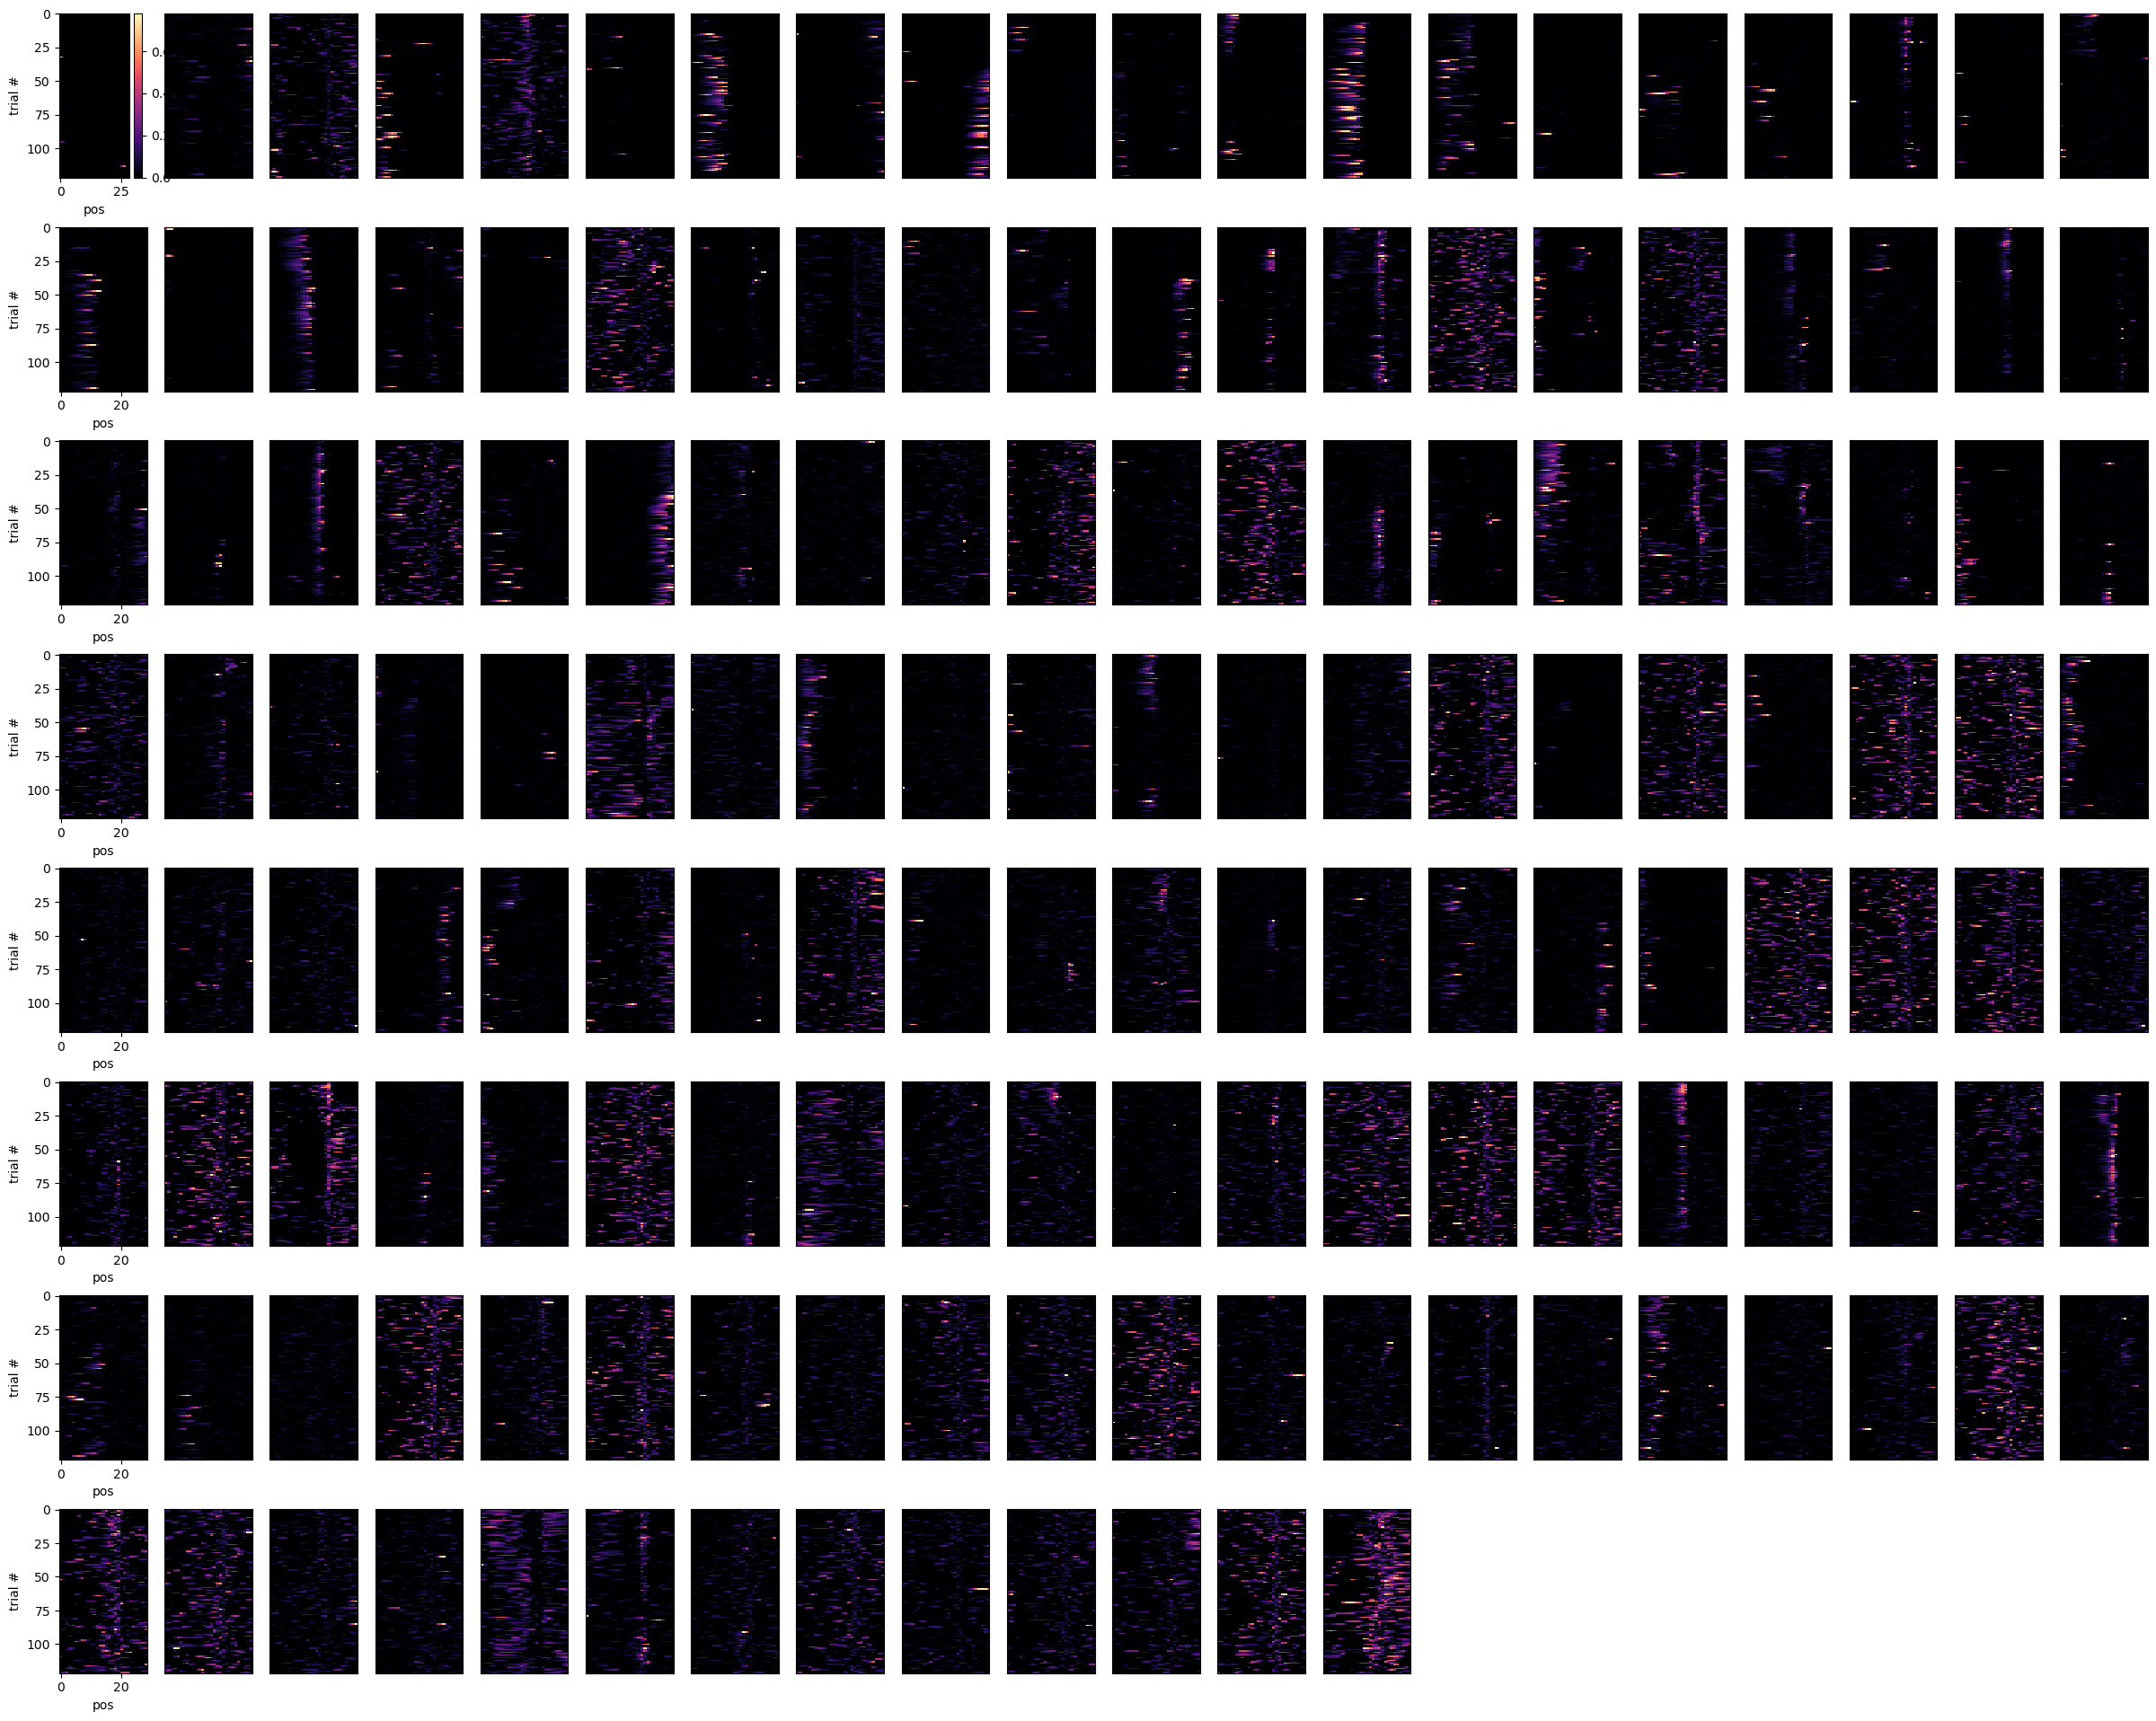

<Figure size 3000x0 with 0 Axes>

In [176]:
# tmat = sess.trial_matrices['channel_0_F_dff_speed_filt']
tmat = sess.trial_matrices['channel_0_spks']

n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(chan0_left_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=pc_idx)

# fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=np.array([r for r in range(n_cells)]))

pc_idx = np.where(chan0_right_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=pc_idx)
# fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [180]:
tmat = sess.trial_matrices['channel_0_spks']
mat = tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:]
mat.shape

(18, 29, 224)

In [181]:
for j in range(mat.shape[1]):  # loop over bins
    bin_data = mat[:, j, :]  # shape: (trials, cells)
    
    if np.isnan(bin_data).all():
        print(f"Bin {j} is entirely NaN across trials and cells")
    elif np.all(bin_data == 0):
        print(f"Bin {j} is all zeros across trials and cells")


In [128]:
sess.trial_matrices['channel_0_spks_smooth'] = np.delete


In [177]:
for k in range(mat.shape[2]):  # loop over cells
    cell_data = mat[:, :, k]  # shape: (trials, bins)
    
    if np.isnan(cell_data).all():
        print(f"Cell {k} is entirely NaN across trials and bins")
    elif np.all(cell_data == 0):
        print(f"Cell {k} is all zeros across trials and bins")


In [182]:
fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=pc_idx)


ValueError: Number of rows must be a positive integer, not 0

<Figure size 3000x0 with 0 Axes>